In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
#SMOTE does not work with sklearn pipeline, thus we have also used imblearn pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn import set_config
set_config(display='diagram')

# import sys
# sys.path.insert(0,'/Users/hagiwara/code/mohit-challa/GiveMeSomeCredit/notebooks/utils')
# from plots import plot_decision_regions

In [2]:
df = pd.read_csv('../raw_data/BankChurners.csv')
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

In [3]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Exploring corelations with heatmap

<AxesSubplot:>

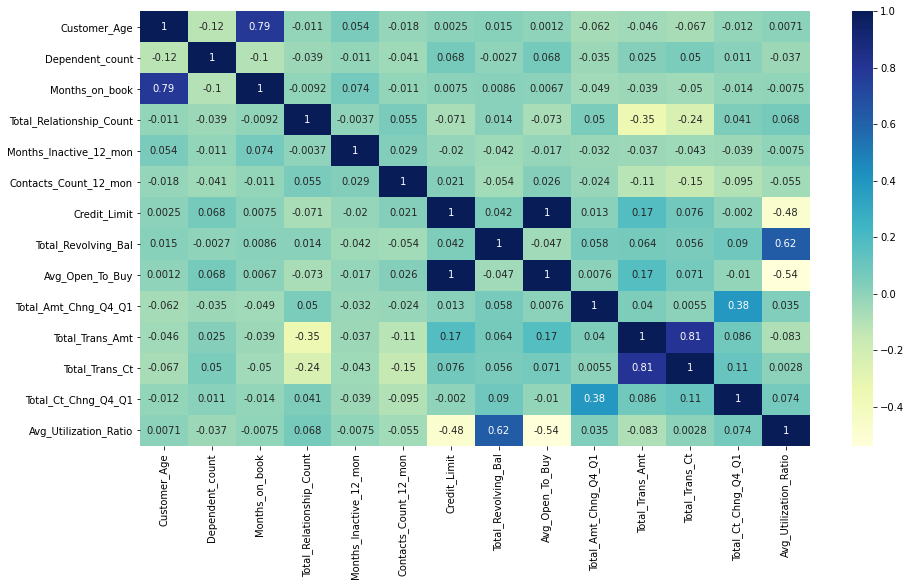

In [4]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15,8)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [5]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

In [6]:
corr_df.head()

,feature_1,feature_2,correlation
118,Avg_Open_To_Buy,Credit_Limit,0.995981
92,Credit_Limit,Avg_Open_To_Buy,0.995981
151,Total_Trans_Amt,Total_Trans_Ct,0.807192
164,Total_Trans_Ct,Total_Trans_Amt,0.807192
28,Months_on_book,Customer_Age,0.788912


Dropping the `Avg_Open_To_Buy` column because of high corelation with `Credit_Limit`

In [7]:
df.drop('Avg_Open_To_Buy',axis=1, inplace=True)

## Hold-out

In [8]:
X = df.drop(['Attrition_Flag','Card_Category','Marital_Status','Gender'], axis=1).copy()
y = df[['Attrition_Flag']].copy()
y['Existing Customer'] = LabelEncoder().fit_transform(df['Attrition_Flag'])
y.drop('Attrition_Flag', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [9]:
X_train.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
5220,39,2,Uneducated,$80K - $120K,36,6,2,4,7901.0,1184,0.863,3667,66,0.784,0.150
6568,58,2,College,Less than $40K,36,6,4,0,2212.0,1902,0.691,4976,79,0.975,0.860
7657,44,3,High School,Less than $40K,35,5,3,0,3398.0,2415,0.891,4509,93,0.661,0.711
9241,34,4,Unknown,Less than $40K,23,1,3,2,7664.0,1785,0.947,15077,126,0.800,0.233
5322,48,2,Unknown,$40K - $60K,43,5,2,2,1761.0,1249,0.936,4410,73,0.622,0.709


## Building pipelines

In [10]:
#List of columns for encoding

#Removed after feature importance: categorical_columns = ['Gender','Marital_Status']

ordinal_columns = ['Education_Level', 'Income_Category']
#Removed after feature importance:'Card_Category'

numerical_columns = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                     'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                    'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio']

#Column categories for ordinal encoding

#Removed after feature importance: card_category = ['Blue', 'Silver', 'Gold', 'Platinum']
education_category = ['Uneducated', 'High School', 'College', 'Unknown', 'Graduate', 'Post-Graduate', 'Doctorate']
income_category = ['Less than $40K', '$40K - $60K', 'Unknown','$60K - $80K', '$80K - $120K', '$120K +']

In [11]:
preprocessing = ColumnTransformer(
    [#('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
     ('ord', OrdinalEncoder(categories=[education_category, income_category]), ordinal_columns), #Removed after feature importance:
     ('num', StandardScaler(), numerical_columns)])

smote = SMOTE(random_state=0)

# log = imbPipeline([
#     ('preprocess', preprocessing),
#     ('smote', smote),
#     ('classifier', LogisticRegression(random_state=0))])

# knn = imbPipeline([
#     ('preprocess', preprocessing),
#     ('smote', smote),
#     ('classifier', KNeighborsClassifier(n_neighbors=3, p=1))])

# svm = imbPipeline([
#     ('preprocess', preprocessing),
#     ('smote', smote),
#     ('classifier', SVC(C=100, kernel='poly', probability=True, random_state=0))])

rf = imbPipeline([
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', RandomForestClassifier(criterion='entropy', min_samples_split=2, n_estimators=500, random_state=0))])

In [12]:
# log.fit(X_train, y_train)
# knn.fit(X_train, y_train)
# svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Uneducated',
                                                                              'High '
                                                                              'School',
                                                                              'College',
                                                                              'Unknown',
                                                                              'Graduate',
                                                                              'Post-Graduate',
                                                                              'Doctorate'],
                                                                             ['Less '
                                                                              'than '
                                                                              '$40K',
                                                                              '$40K '
                                                                              '- '
                                                                              '$60K',
                                                                              'Unknown',
                                                                              '$60K '
                                                                              '- '
                                                                              '$80K',
                                                                              '$80K '
                                                                              '- '
                                                                              '$120K',
                                                                              '$120K '
                                                                              '+']]),
                                                  ['Education_Level',
                                                   'Income_Category']),
                                                 ('num', StandardScaler(),
                                                  ['Custome...
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Amt',
                                                   'Total_Trans_Ct',
                                                   'Total_Ct_Chng_Q4_Q1',
                                                   'Avg_Utilization_Ratio'])])),
                ('smote', SMOTE(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=500,
                                        random_state=0))])

## Logistic Regression: Cross Validation

In [13]:
# log_cv_results = cross_validate(log, X_train, y_train, cv=10, 
#                             scoring=['accuracy','recall','precision','f1'])

In [14]:
# print('Accuracy:\n', log_cv_results['test_accuracy'].mean())
# print('\nRecall\n', log_cv_results['test_recall'].mean())
# print('\nPrecision\n', log_cv_results['test_precision'].mean())
# print('\nf1:\n', log_cv_results['test_f1'].mean())

## KNN Classifier

In [15]:
# knn_cv_results = cross_validate(knn, X_train, y_train, cv=10, 
#                             scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [16]:
# print('Accuracy:\n', knn_cv_results['test_accuracy'].mean())
# print('\nRecall:\n', knn_cv_results['test_recall'].mean())
# print('\nPrecision:\n', knn_cv_results['test_precision'].mean())
# print('\nf1:\n', knn_cv_results['test_f1'].mean())

Update `knn_cv_results` with the best params.

## SVM

In [17]:
#svm_cv_results = cross_validate(svm, X_train, y_train, cv=5, 
#                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [18]:
# print('Accuracy:\n', svm_cv_results['test_accuracy'].mean())
# print('\nRecall:\n', svm_cv_results['test_recall'].mean())
# print('\nPrecision:\n', svm_cv_results['test_precision'].mean())
# print('\nf1:\n', svm_cv_results['test_f1'].mean())

## Random Forest

In [19]:
rf_cv_results = cross_validate(rf, X_train, y_train, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [20]:
print('Accuracy:\n', rf_cv_results['test_accuracy'].mean())
print('\nRecall:\n', rf_cv_results['test_recall'].mean())
print('\nPrecision:\n', rf_cv_results['test_precision'].mean())
print('\nf1:\n', rf_cv_results['test_f1'].mean())

Accuracy:
 0.9614881321906388

Recall:
 0.9759704147360129

Precision:
 0.9781613444718568

f1:
 0.9770535251313766


## Inspecting AUC scores to select the best model

In [21]:
# log_auc_score = roc_auc_score(y_test, log.predict_proba(X_test)[:,1], multi_class='ovr')
# knn_auc_score = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1], multi_class='ovr')
# svm_auc_score = roc_auc_score(y_test, svm.predict_proba(X_test)[:,1], multi_class='ovr')
rf_auc_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1], multi_class='ovr')

# print('\nLogistic Regression AUC score: ',log_auc_score)
# print('\nKNN Classifier AUC score: ',knn_auc_score)
# print('\nSVM Classifier AUC score: ',svm_auc_score)
print('\nRandom Forest Classifier AUC score: ',rf_auc_score)


Random Forest Classifier AUC score:  0.9897250715232713


Text(0.5, 1.0, 'Precision-Recall curve')

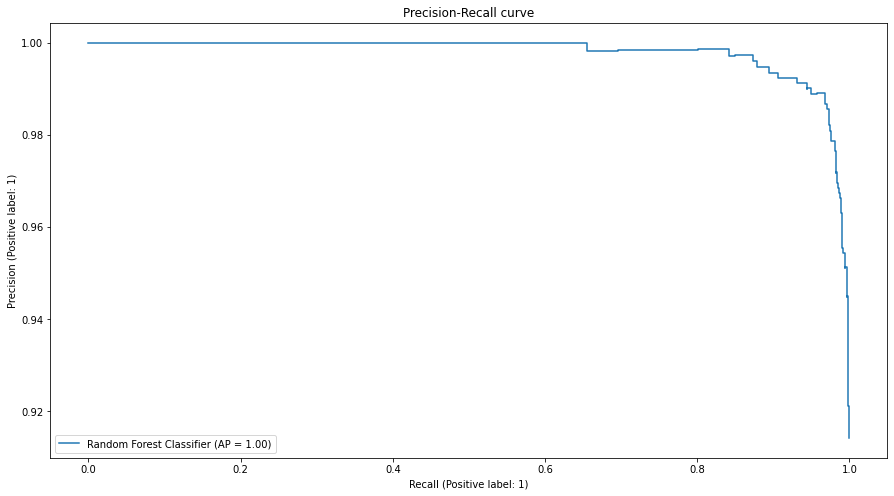

In [22]:
fig = plt.gcf()
fig.set_size_inches(15, 8)

# plot_precision_recall_curve(log, X_test, y_test, ax = plt.gca(),name = 'Logistic Regression')
# plot_precision_recall_curve(knn, X_test, y_test, ax = plt.gca(),name = 'KNN Classifier')
# plot_precision_recall_curve(svm, X_test, y_test, ax = plt.gca(),name = 'SVM Classifier')
plot_precision_recall_curve(rf, X_test, y_test, ax = plt.gca(),name = 'Random Forest Classifier')

plt.title('Precision-Recall curve')

### From precision-recall curves, Random Forest classifier is the best model for the given task.

## Checking Feature Importances

In [23]:
#Collecting feature importances

feat_imp = rf.named_steps["classifier"].feature_importances_

In [24]:
#Returns the names of columns from the pipeline

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [25]:
#Collecting feature names

feat_names = get_column_names_from_ColumnTransformer(rf["preprocess"])

In [26]:
#Mapping feature importances to feature names

forest_importances = pd.Series(feat_imp, index=feat_names).sort_values(ascending=False)

<AxesSubplot:>

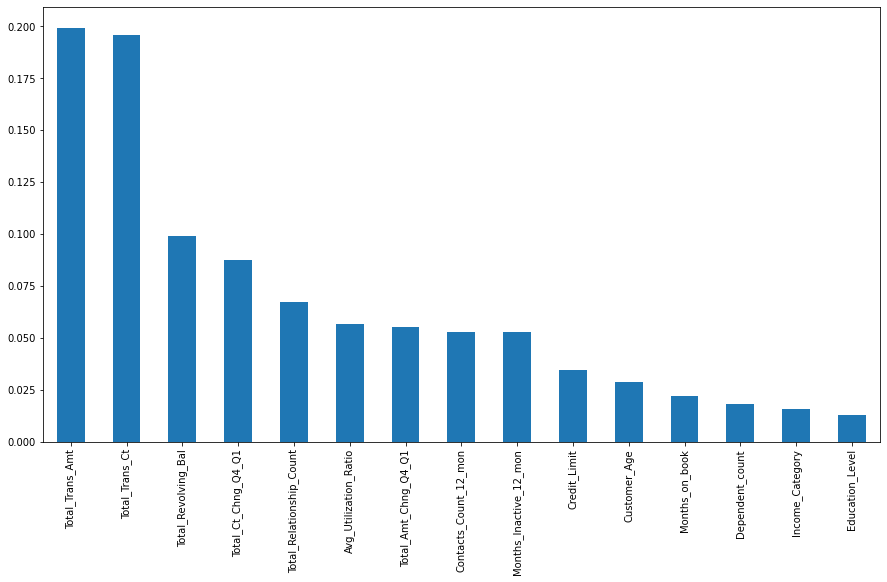

In [27]:
#Visually inspecting importance of each feature

fig = plt.gcf()
fig.set_size_inches(15, 8)

forest_importances.plot.bar()

## Making Recommendation

In [28]:
proba = rf.predict_proba(X_test.iloc[[10]])[0][1]*100
fac = 1

while proba < 50:
    fac += 0.01
    
    X_temp = X_test.iloc[[10]]
    X_temp.Total_Trans_Ct = X_temp.Total_Trans_Ct*fac
    X_temp.Total_Trans_Amt = X_temp.Total_Trans_Amt*fac
    
    proba = rf.predict_proba(X_temp)[0][1]*100
    state = rf.predict(X_temp)[0]
    
    print('Probability of customer existing: ',proba)
    print('Customer existing: ',state)
    print('Percentage increase in Total_Trans_Ct and Total_Trans_Amt: ',round((fac-1)*100), '%')
    print('*** Loop ended ***\n')

Probability of customer existing:  48.6
Customer existing:  0
Percentage increase in Total_Trans_Ct and Total_Trans_Amt:  1 %
*** Loop ended ***

Probability of customer existing:  50.2
Customer existing:  1
Percentage increase in Total_Trans_Ct and Total_Trans_Amt:  2 %
*** Loop ended ***



This suggests that if we encurage the customer @ `X_test.iloc[[10]]` to increase their `Total_Trans_Ct` and `Total_Trans_Amt` by just `2%`, the customer is likely to stay with the bank.

In [33]:
churning = X_test.iloc[10]
column_name = ['Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category','Card_Category','Months_on_book','Total_Relationship_Count',
    'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt',
    'Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
df = pd.DataFrame(data =churning , columns= column_name)
churning

Customer_Age                         41
Dependent_count                       4
Education_Level              Uneducated
Income_Category             $40K - $60K
Months_on_book                       36
Total_Relationship_Count              3
Months_Inactive_12_mon                2
Contacts_Count_12_mon                 3
Credit_Limit                    19704.0
Total_Revolving_Bal                   0
Total_Amt_Chng_Q4_Q1              0.682
Total_Trans_Amt                    7766
Total_Trans_Ct                       81
Total_Ct_Chng_Q4_Q1                0.62
Avg_Utilization_Ratio               0.0
Name: 8656, dtype: object

In [30]:



proba = rf.predict_proba(churning)[0][1]*100
fac = 1

while proba < 50:
    fac += 0.01
    
    X_temp = churning
    X_temp.Total_Trans_Ct = X_temp.Total_Trans_Ct*fac
    X_temp.Total_Trans_Amt = X_temp.Total_Trans_Amt*fac
    
    proba = rf.predict_proba(X_temp)[0][1]*100
    state = rf.predict(X_temp)[0]
    
    print('Probability of customer existing: ',proba)
    print('Customer existing: ',state)
    print('Percentage increase in Total_Trans_Ct and Total_Trans_Amt: ',round((fac-1)*100), '%')
    print('*** Loop ended ***\n')

KeyError: "None of [Int64Index([10], dtype='int64')] are in the [columns]"

In [31]:
X_test[[10]]

KeyError: "None of [Int64Index([10], dtype='int64')] are in the [columns]"

In [79]:
def recommendation(churning,model):
    churning = churning.iloc[[0]]
    print(churning)
    proba = model.predict_proba(churning)[0][1]*100
    fac = 1
    state = 1
    while proba < 50:
      fac += 0.01
      X_temp = churning
      X_temp.Total_Trans_Ct = X_temp.Total_Trans_Ct*fac
      X_temp.Total_Trans_Amt = X_temp.Total_Trans_Amt*fac
      proba = model.predict_proba(X_temp)[0][1]*100
      state = model.predict(X_temp)[0]
    change = (fac-1)*100
    return change, proba, state

In [69]:
recommendation(X_test, rf)

      Customer_Age  Dependent_count Education_Level Income_Category  \
3358            44                5      Uneducated     $60K - $80K   

      Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
3358              39                         5                       2   

      Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
3358                      0       16034.0                 1597   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
3358                 0.775             3628              59   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
3358                0.903                    0.1  


(0, 99.0, 1)

In [73]:
input_list = [[62,"F",0,"Graduate","Married","Less than $40K","Blue",49,2,3,3,1438.3,0,1.047,692,16,0.6,0.99616]]
df = pd.DataFrame(data = input_list, columns= column_name)
df

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1.047,692,16,0.6,0.99616


In [74]:
def prediction_input(input_list,model):
    column_name = ['Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category','Card_Category','Months_on_book','Total_Relationship_Count',
    'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt',
    'Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
    df = pd.DataFrame(data = input_list, columns= column_name)
    #model = joblib.load('credit_new_model.joblib')
    prediction = model.predict(df)
    df['Prediction'] = prediction
    return df

In [75]:
result_input = prediction_input(input_list,model)

In [76]:
result_input

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Prediction
0,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1.047,692,16,0.6,0.99616,0


In [77]:
X = result_input[column_name]
y = result_input['Prediction']

In [78]:
X

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1.047,692,16,0.6,0.99616


In [80]:
change, proba, state = recommendation(X,model)

   Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0            62      F                0        Graduate        Married   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0  Less than $40K          Blue              49                         2   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       3                      3        1438.3   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                    0                 1.047              692              16   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0                  0.6                0.99616  


In [81]:
change, proba, state

(17.000000000000014, 53.2, 1)

In [86]:
X_temp = X.iloc[[0]]
X_temp.Total_Trans_Ct = X_temp.Total_Trans_Ct.values[0]*fac
X_temp.Total_Trans_Amt = X_temp.Total_Trans_Amt.values[0]*fac

In [87]:
X_temp.Total_Trans_Ct

0    16.32
Name: Total_Trans_Ct, dtype: float64